# Transfert Learning with TensorFlow part 3: Scaling up
Food Vision Mini

We've seen the power of tranfer learning feature extraction and fine-tuning, now it'is time to scale up all of the lcasses in Food101

our goal is to beat the original Food101 paper with 10% of the training data leveraging deep learning !

In [1]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [2]:
# Check if we are using a GPU
!nvidia-smi

Sat Oct 12 11:28:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   50C    P8              13W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper function

In previous notebooks, we have create a series of helper function to do different tasks, let's download them

In [3]:
# download the helper function *.py file
!wget "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py"

--2024-10-12 11:28:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-10-12 11:28:29 (15.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# import our function
from helper_functions import *

## 101 Food classes: working with less data

Our goal is to beat the original Food1O1 paper with 10% of the training data -> let's download it


In [5]:
#download the first data set
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip"
unzip_data("101_food_classes_10_percent.zip")

--2024-10-12 11:28:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  85.0MB/s    in 16s     

2024-10-12 11:28:46 (97.0 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
# prepare the directories:
train_dir_10_percent = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [7]:
# check how many images are there
walk_through_dir(train_dir_10_percent)

There are 101 directories and 0 images in '101_food_classes_10_percent/train/'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pork_chop'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/apple_pie'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/mussels'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tacos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/churros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spring_rolls'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/club_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/guacamole'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheese_plate'.
There are 0 directories and 75 im

In [8]:
# Set up our input data
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=32,
                                                                            seed = 42)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=32,
                                                                           seed=42,
                                                                           shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
1. Create a model checkpoint callback (save the model as it trains)
2. Create a data augmentation layer to build data augmentation right into the model. Since we have more classes we want to see what this affect the model
3. Build headless (no top layers) Functional EfficientNetBO backboned-model (we will create our own outputs)
4. Compile our model
5. Feature Extract for 5 full epochs and validate on 50% of the test data to save epochs time

In [9]:
# Create a model Checkpoint callback
checkpoint_path = "101_classes_1O_percent_data_model_checkpoint/checkpoint.weights.h5"
check_point_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                          save_weights_only=True,
                                                          monitor="val_accuracy",
                                                          save_best_only=True)

In [10]:
# Create a data augmentation layer
data_augmentation_layer = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2)
], name="data_augmentation_layer")

Note: since we use efficient net B0 already scales the image ! so in our data augmentation layer, we do not need to rescale using this:
`tf.keras.Rescaling(1./255)`

**Note**: when defining the shape we need to take the habit to anaylse the data in order to determine which is the size of our inputs !

In [11]:
# Built the backbone model using EfficientNetBO
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # no top since we will plug our own
base_model.trainable = False # we do not want to train anything from the base model !!!!

# define the inputs and outputs of our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer") # in functional API we need to explicitly "declare" the input layer
x = data_augmentation_layer(inputs)
x = base_model(x, training=False) # we do not want to train
x = tf.keras.layers.GlobalAveragePooling2D()(x) # flattens the layer prior to the dense layer while keeping the information
outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)
# build the model
model_0 = tf.keras.Model(inputs, outputs)

# compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# summary of the model
model_0.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation_layer (Sequential) │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [13]:
# fit the model
history_0 = model_0.fit(train_data_10_percent, epochs=5, validation_data=test_data,
                        callbacks=[check_point_callback], validation_steps=int(0.15*len(test_data)))

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 120ms/step - accuracy: 0.1373 - loss: 4.0871 - val_accuracy: 0.3189 - val_loss: 2.9300
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 26s 111ms/step - accuracy: 0.3976 - loss: 2.6276 - val_accuracy: 0.4166 - val_loss: 2.3339
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - accuracy: 0.4775 - loss: 2.2143 - val_accuracy: 0.5577 - val_loss: 1.7829
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 25s 106ms/step - accuracy: 0.5202 - loss: 1.9700 - val_accuracy: 0.5342 - val_loss: 1.8736
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 25s 105ms/step - accuracy: 0.5629 - loss: 1.8131 - val_accuracy: 0.6096 - val_loss: 1.5938


In [14]:
# Evaluate on the whole test data set
feature_extration_resutl = model_0.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.5012 - loss: 1.9613


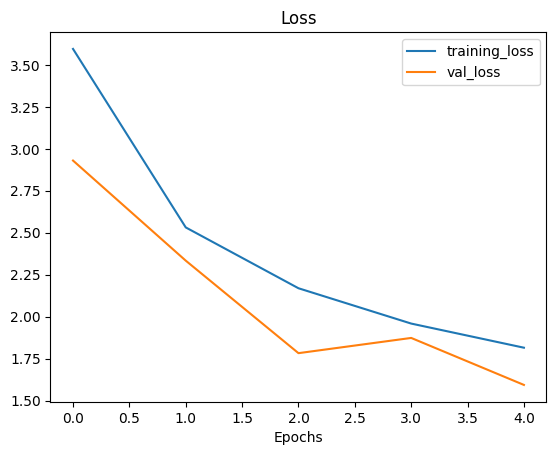

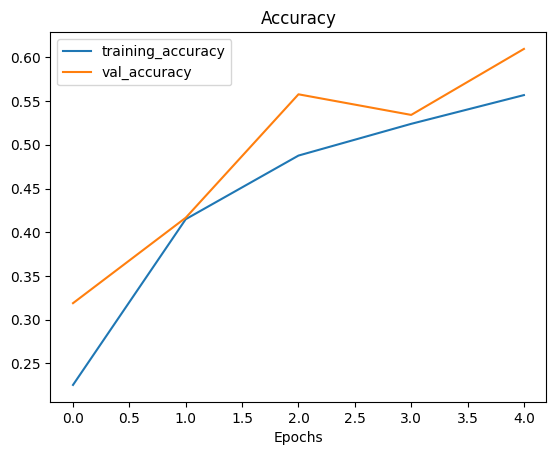

In [15]:
#plot loss curves
plot_loss_curves(history_0)

## Fine tuning

In [16]:
# Unfreez all of the layers in the base model and then reset those we want to false !
base_model.trainable = True
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [17]:
# check if everything went as expect
for layer in base_model.layers:
  print(layer.name, layer.trainable)

input_layer False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [18]:
# now let's load our previous model (to get its weights and recompile)
model_0.load_weights(checkpoint_path)

In [19]:
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [20]:
for layer in model_0.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation_layer True
efficientnetb0 True
global_average_pooling2d True
output_layer True


In [21]:
history_0_fine_tune = model_0.fit(train_data_10_percent, epochs=10, initial_epoch=history_0.epoch[-1],
            validation_data=test_data,
            validation_steps=int(0.15*len(test_data)))

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 111ms/step - accuracy: 0.5735 - loss: 1.7594 - val_accuracy: 0.5238 - val_loss: 1.8543
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 25s 104ms/step - accuracy: 0.6376 - loss: 1.5217 - val_accuracy: 0.5818 - val_loss: 1.5923
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.6555 - loss: 1.3923 - val_accuracy: 0.6186 - val_loss: 1.4581
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - accuracy: 0.6700 - loss: 1.3025 - val_accuracy: 0.5990 - val_loss: 1.5054
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - accuracy: 0.6838 - loss: 1.2456 - val_accuracy: 0.6634 - val_loss: 1.2928
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 23s 98ms/step - accuracy: 0.7094 - loss: 1.1770 - val_accuracy: 0.6290 - val_loss: 1.3342


In [22]:
fine_tune_results = model_0.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.5918 - loss: 1.5348


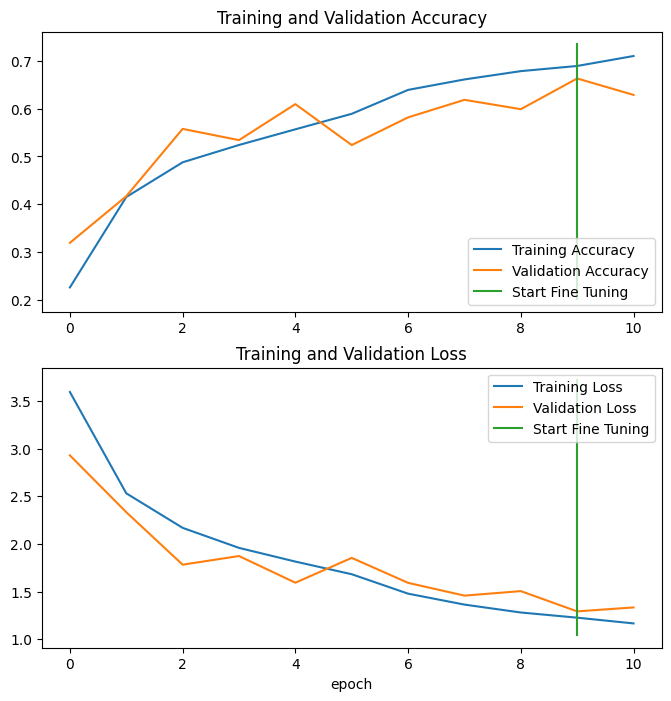

In [23]:
#compare the histories of feature extrations
compare_historys(history_0, history_0_fine_tune, 10)

It seems that fine tuning allowed gains for the training accuracy -> slight overfitting so we need to avoid overfitting.

## Save and load our model

To use our model in an external application, we will need to save it and export it somewhere !

In [24]:
# save our fine-tuned model
model_0.save("/content/drive/MyDrive/Colab Notebooks/101_food_classes_10_percent_data_model_0.keras")

In [25]:
#load and evaluate the saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/101_food_classes_10_percent_data_model_0.keras")

In [26]:
lm_results = loaded_model.evaluate(test_data)
lm_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.5918 - loss: 1.5348


[1.4391205310821533, 0.6152079105377197]

In [27]:
import numpy as np

In [28]:
np.isclose(fine_tune_results, lm_results)

array([ True,  True])

## Evaluation the perfoamnce of the big dog model accross all different classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [29]:
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

--2024-10-12 11:35:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  80.6MB/s    in 0.6s    

2024-10-12 11:35:53 (80.6 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [30]:
#loading saved model
loaded_model_bd = tf.keras.layers.TFSMLayer("/content/06_101_food_class_10_percent_saved_big_dog_model", call_endpoint="serving_default")

In [138]:
# evaluate our second loaded model
# Iterate over test_data and get only the input part (ignoring labels)
all_predictions = []
for x_batch, y_batch in test_data:  # x_batch: input images, y_batch: labels

    predictions_bd = loaded_model_bd(x_batch)
    #print(predictions_bd)  # or store these predictions for further analysis
    all_predictions.append(predictions_bd)

(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 

KeyboardInterrupt: 

In [32]:
for item in all_predictions[:10]:
  print(item["dense_8"].shape)

(32, 101)
(32, 101)
(32, 101)
(32, 101)
(32, 101)
(32, 101)
(32, 101)
(32, 101)
(32, 101)
(32, 101)


In [33]:
print(tf.math.argmax(all_predictions[0]['dense_8'][0])), sum(all_predictions[0]['dense_8'][0])

tf.Tensor(52, shape=(), dtype=int64)


(None, <tf.Tensor: shape=(), dtype=float32, numpy=0.9999999>)

Our model outputs a prediction probability array (with N number of variables where N is the number of classes) for each sample passed to the predict method

In [34]:
list_classes = test_data.class_names

In [35]:
len(all_predictions[789]["dense_8"])

2

In [36]:
# Get the predicted classes for each label in the dataset
all_pred_classes = []

# Loop through all predictions
for batch in all_predictions:
    # Get the dense layer outputs from the predictions
    dense_output = batch['dense_8']

    # Use tf.argmax on the entire batch and convert it to numpy array
    pred_classes = tf.math.argmax(dense_output, axis=1).numpy()

    # Extend the results to the final list
    all_pred_classes.extend(pred_classes)

# Show the first 10 predicted classes
all_pred_classes[:10]


[52, 0, 0, 80, 79, 61, 29, 0, 85, 0]

Now we have got a predicton array of all of our model's predictions, we need to compare them to the original label

In [37]:
# to get our test labels we need to unravel our test_data BatchDataSet
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [38]:
# how many y_labels are there ?
len(y_labels)

25250

## Evaluating our model's predictions

one way to check to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score for each predicted classes !

In [39]:
# let's try sklearn accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, all_pred_classes) # work only if the y_true and y_preds are on the same format !!!!

In [40]:
sklearn_accuracy

0.6077227722772277

In [41]:
# does this metrics come close to our model's evaluate resutls
import numpy as np
#np.isclose()

## Let's get visualize making a confusion matrix

In [44]:
make_confusion_matrix(y_labels, all_pred_classes, list_classes, figsize=(100,100), text_size=20)

Output hidden; open in https://colab.research.google.com to view.

## Let's keep the evaluation train going: time for a classification report

sklearn has a helpul function for acquiring many diffrent classification metrics per class (e.g., precision ,recall, f1, classification report, etc.)

In [45]:
# import classification metrics from sklearn
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

In [46]:
print(classification_report(y_labels, all_pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.52      0.61       250
           4       0.74      0.44      0.55       250
           5       0.35      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.52       250
          10       0.62      0.42      0.50       250
          11       0.83      0.48      0.61       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

the numbers above provide a good class by class evaluation of our model. However so many classes are quite difficult to understand

In [47]:
# let create a plot of each class and their respective f1-score
classification_report_dict = classification_report(y_labels, all_pred_classes, output_dict=True)

In [53]:
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584906,
  'support': 250.0},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250.0},
 '2': {'precision': 0.5605536332179931,
  'recall': 0.648,
  'f1-score': 0.601113172541744,
  'support': 250.0},
 '3': {'precision': 0.7401129943502824,
  'recall': 0.524,
  'f1-score': 0.6135831381733021,
  'support': 250.0},
 '4': {'precision': 0.7364864864864865,
  'recall': 0.436,
  'f1-score': 0.5477386934673367,
  'support': 250.0},
 '5': {'precision': 0.3452685421994885,
  'recall': 0.54,
  'f1-score': 0.42121684867394693,
  'support': 250.0},
 '6': {'precision': 0.6700680272108843,
  'recall': 0.788,
  'f1-score': 0.7242647058823529,
  'support': 250.0},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511387,
  'support': 250.0},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.386694386694

Let's plot all of our f1-score

In [56]:
classification_report_dict.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', 'accuracy', 'macro avg', 'weighted avg'])

In [83]:
# create empty dictionnary
class_f1_score = dict()
# loop through classification report dictionary items
for key, value in classification_report_dict.items():
  if key == "accuracy":
    break
  class_f1_score[list_classes[int(key)]] = value["f1-score"]
class_f1_score

{'apple_pie': 0.24056603773584906,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.601113172541744,
 'beef_carpaccio': 0.6135831381733021,
 'beef_tartare': 0.5477386934673367,
 'beet_salad': 0.42121684867394693,
 'beignets': 0.7242647058823529,
 'bibimbap': 0.7908902691511387,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5152224824355972,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6126582278481013,
 'cannoli': 0.6125827814569537,
 'caprese_salad': 0.5775193798449613,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.37122969837587005,
 'cheese_plate': 0.5662650602409639,
 'cheesecake': 0.426890756302521,
 'chicken_curry': 0.5,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7074569789674953,
 'chocolate_cake': 0.4526166902404526,
 'chocolate_mousse': 0.325,
 'churros': 0.7134935304990758,
 'clam_chowder': 0.7708779443254818,
 'club_sandwich': 0.7325102880658436,
 'crab_cakes': 0.46153846153846156,
 'creme_brulee': 0.7494824016563147,
 'cro

In [65]:
class_f1_score.items()

dict_items([('apple_pie', 0.24056603773584906), ('baby_back_ribs', 0.5864406779661017), ('baklava', 0.601113172541744), ('beef_carpaccio', 0.6135831381733021), ('beef_tartare', 0.5477386934673367), ('beet_salad', 0.42121684867394693), ('beignets', 0.7242647058823529), ('bibimbap', 0.7908902691511387), ('bread_pudding', 0.3866943866943867), ('breakfast_burrito', 0.5152224824355972), ('bruschetta', 0.5047619047619047), ('caesar_salad', 0.6126582278481013), ('cannoli', 0.6125827814569537), ('caprese_salad', 0.5775193798449613), ('carrot_cake', 0.574757281553398), ('ceviche', 0.37122969837587005), ('cheese_plate', 0.5662650602409639), ('cheesecake', 0.426890756302521), ('chicken_curry', 0.5), ('chicken_quesadilla', 0.6411889596602972), ('chicken_wings', 0.7074569789674953), ('chocolate_cake', 0.4526166902404526), ('chocolate_mousse', 0.325), ('churros', 0.7134935304990758), ('clam_chowder', 0.7708779443254818), ('club_sandwich', 0.7325102880658436), ('crab_cakes', 0.46153846153846156), ('c

In [86]:
# sort the dictionay by ascending value order
class_f1_score_sorted = sorted(class_f1_score.items(), key=lambda item: item[1], reverse=True)
#class_f1_score_sorted = dict(class_f1_score[1:])
#class_f1_score_sorted
class_f1_score_sorted = dict(class_f1_score_sorted)
class_f1_score_sorted

{'edamame': 0.9371428571428572,
 'macarons': 0.895397489539749,
 'pho': 0.8682170542635659,
 'spaghetti_carbonara': 0.84765625,
 'oysters': 0.8340080971659919,
 'onion_rings': 0.8326180257510729,
 'mussels': 0.82,
 'seaweed_salad': 0.814663951120163,
 'miso_soup': 0.8129770992366412,
 'hot_and_sour_soup': 0.8103448275862069,
 'frozen_yogurt': 0.8083491461100569,
 'bibimbap': 0.7908902691511387,
 'spaghetti_bolognese': 0.7881548974943052,
 'dumplings': 0.7855787476280834,
 'pizza': 0.7833001988071571,
 'guacamole': 0.7783783783783784,
 'sashimi': 0.7783783783783784,
 'clam_chowder': 0.7708779443254818,
 'hot_dog': 0.7644444444444445,
 'french_fries': 0.7622641509433963,
 'poutine': 0.7603305785123967,
 'creme_brulee': 0.7494824016563147,
 'deviled_eggs': 0.7476190476190476,
 'donuts': 0.7341772151898734,
 'club_sandwich': 0.7325102880658436,
 'beignets': 0.7242647058823529,
 'eggs_benedict': 0.7238805970149254,
 'escargots': 0.7158351409978309,
 'churros': 0.7134935304990758,
 'pad_thai

In [90]:
# create a datafram
import pandas as pd
class_f1_score_df = pd.DataFrame(class_f1_score_sorted.items(), columns=["Class", "F1-Score"])
class_f1_score_df

,Class,F1-Score
0,edamame,0.937143
1,macarons,0.895397
2,pho,0.868217
3,spaghetti_carbonara,0.847656
4,oysters,0.834008
...,...,...
96,huevos_rancheros,0.336134
97,chocolate_mousse,0.325000
98,pork_chop,0.304850
99,foie_gras,0.297491


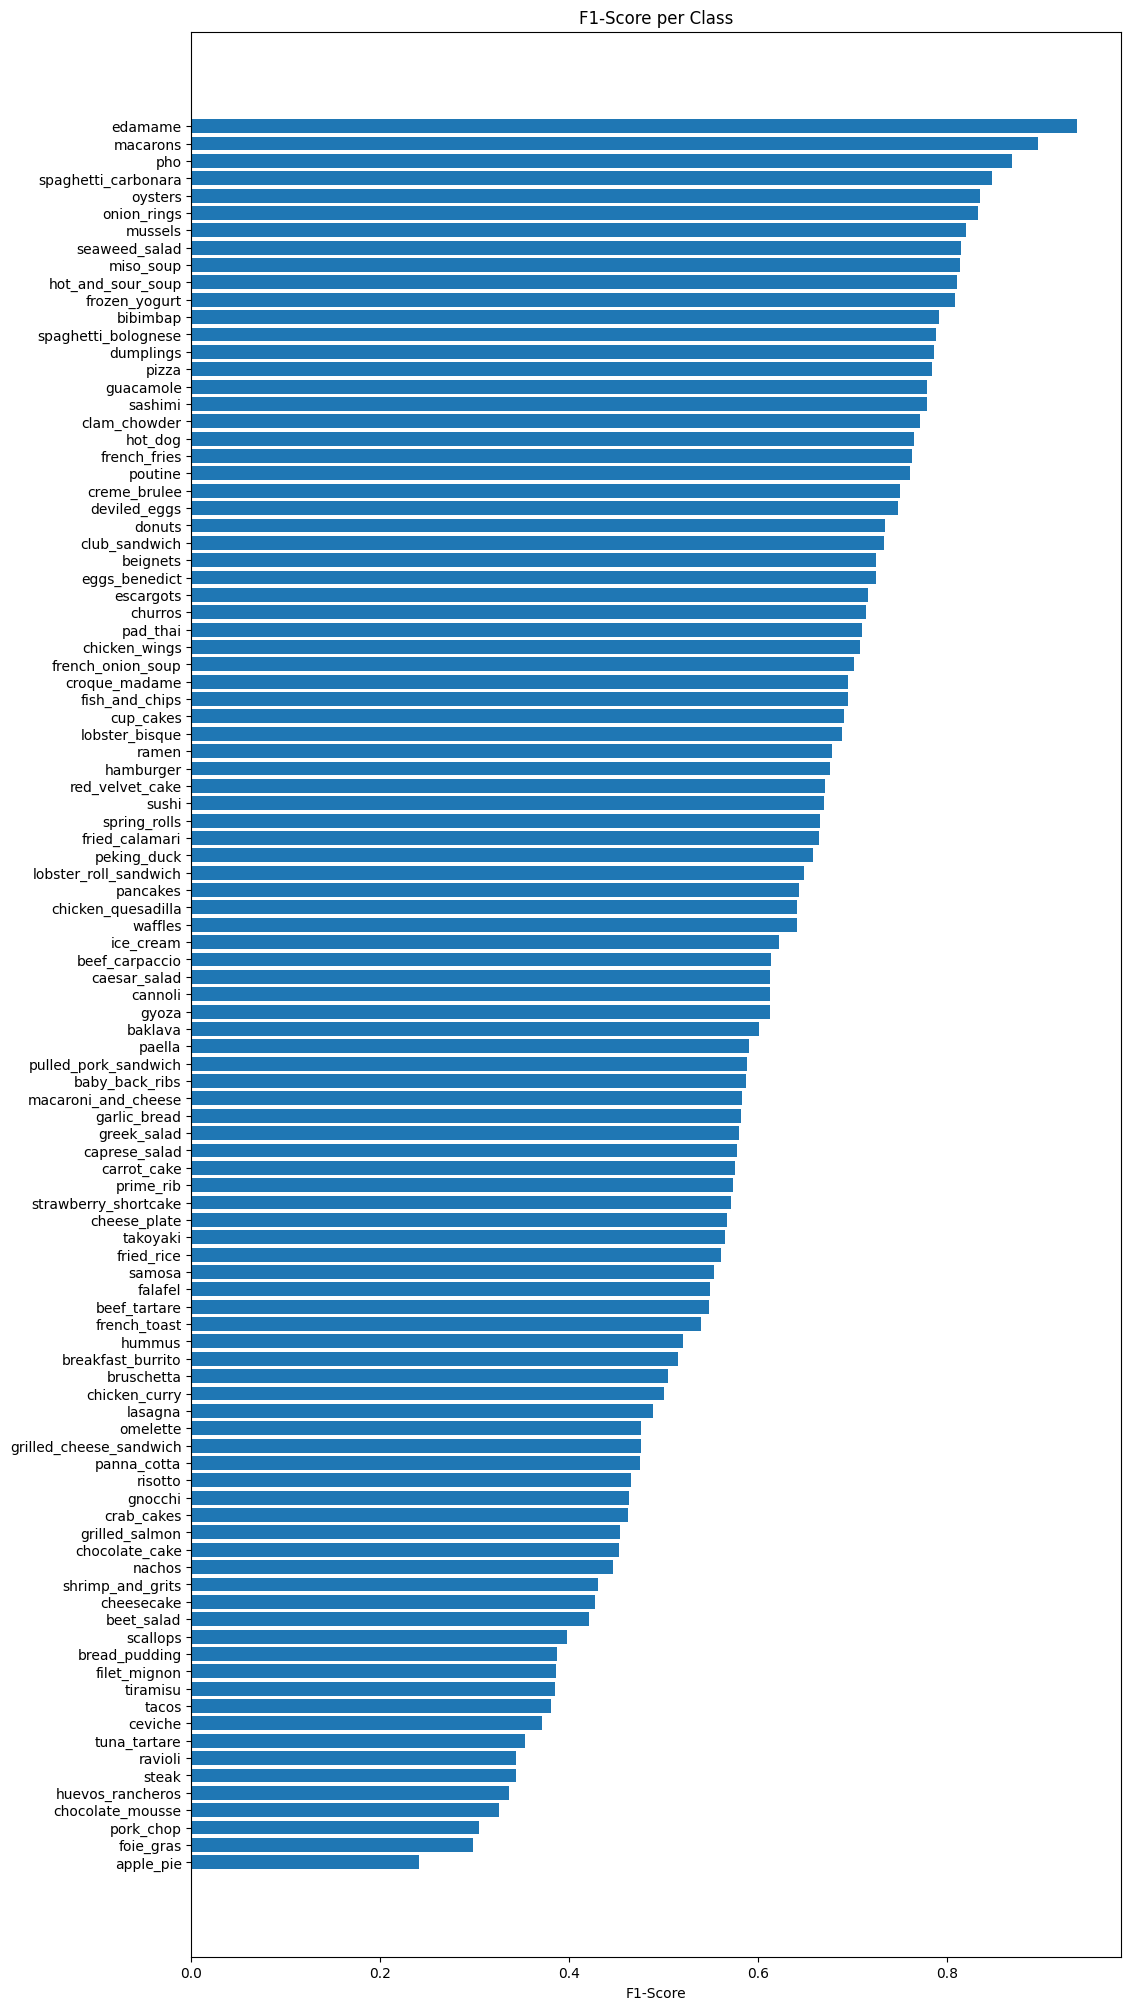

In [98]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(class_f1_score_df)), class_f1_score_df["F1-Score"]);
ax.set_yticks(range(len(class_f1_score_df)));
ax.set_yticklabels(class_f1_score_df["Class"]);
ax.set_xlabel("F1-Score");
ax.set_title("F1-Score per Class");
ax.invert_yaxis();
plt.show()
# adding value of the end of each bar using the auto-label


## Visualizing on own images

this is the real test !

to visualize our model's prediction on our own images, we will need a function to lod and preprocess images, specifically it will need to:

1. Read in a target image filepath using tf.io.read_file()
2. Turn the image into a Tensor using tf.io.decode_image()
3. Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
4. Rescale if needed (not the case with efficientNetB0)

In [105]:
# Create a function to load an prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads an image from filename, turns it into a tensor and reshapes it to (img_shape, img_shape, color_channels)
  """
  # Read the image
  raw = tf.io.read_file(filename)

  #decode
  img = tf.io.decode_image(raw, channels=3)

  # Resize the image
  img = tf.image.resize(img, size=(img_shape, img_shape))

  # Rescale the image (if necessary)
  if scale:
    return img/255.
  else:
    return img


Now we have got a function to load and prepare target images. Let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we will write some code to:
1. load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the orginal images(s) along with the model's predictions probability and truth label

In [139]:
# Makes preds on a series of random images
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  class_names = random.choice(list_classes)
  filename = random.choice(os.listdir(test_dir + "/" + class_names))
  filepath = test_dir + "/" + class_names + "/" + filename
  img = load_and_prep_image(filepath, scale=True)
  img = tf.expand_dims(img, axis=0)
  print(img.shape)
  pred = loaded_model_bd(img)
  pred = pred["dense_8"]
  print(pred[0].numpy().argmax())
  #pred_class = list_classes[pred.numpy().argmax()]
  #print("Pred: ", pred_class)
  #print("Truth: ", class_names)
  #plt.subplot(1,3,i+1)
  #plt.imshow(img)
  #plt.title(f"Pred: {pred_class},\n Truth: {class_names}")
  #plt.axis(False)


(1, 224, 224, 3)
64
(1, 224, 224, 3)
64
(1, 224, 224, 3)
64


<Figure size 1700x1000 with 0 Axes>

In [140]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(17,10))
for i in range(3):
    class_names = random.choice(list_classes)
    filename = random.choice(os.listdir(test_dir + "/" + class_names))
    filepath = test_dir + "/" + class_names + "/" + filename

    # Load and preprocess the image
    img = load_and_prep_image(filepath, scale=True)
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    print(img.shape)

    # Force the model into inference mode (training=False)
    pred = loaded_model_bd(img, training=False)  # Important!

    # Get the prediction
    pred = pred["dense_8"]
    print(pred[0].numpy().argmax())  # Check the predicted class index

    # Continue with plotting or further analysis


(1, 224, 224, 3)
64
(1, 224, 224, 3)
64
(1, 224, 224, 3)
64


<Figure size 1700x1000 with 0 Axes>

## Finding the most wrong predictions

To find out where our model is most wrong, leet's write some code to find out the following:
1. Get all the images file paths in the test data using list_files() method
2. Createt a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities.
3. Use our dataframe to find all the wrong predictions (where groung trutu label does not match the prediction).
3. Sort the dataframe based on wrong predictions (have the hightest prediction probability prediction at the top).
5. Visualize the image with the highest prediction probalitis but have the wrong predictions.


In [141]:
#get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepaths.append(filepath.numpy())


In [142]:
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# 2. Create aDF of different parameters for each
pred_df = pd.DataFrame({"img_path":filepaths,
                        "y_true":y_labels,
                        "y_pred":all_pred_classes,
                        "max_pred_prob":np.max(all_predictions, axis=1),
                        })